In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-11-26 03:38:19.987207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764128300.154984      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764128300.204901      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [2]:
# Định nghĩa Model Architecture (phải giống với model đã train)
class DistilBertLSTMClassifier(nn.Module):
    def __init__(self, n_classes=3, lstm_hidden_size=128, lstm_layers=2, dropout=0.3):
        super(DistilBertLSTMClassifier, self).__init__()
        
        # DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=768,  # DistilBERT hidden size
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classifier
        self.fc = nn.Linear(lstm_hidden_size * 2, n_classes)  # *2 for bidirectional
        
    def forward(self, input_ids, attention_mask):
        # DistilBERT embeddings
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # last_hidden_state: [batch_size, seq_len, 768]
        sequence_output = distilbert_output.last_hidden_state
        
        # LSTM
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        
        # Lấy output từ hidden state cuối cùng của cả 2 directions
        hidden_fwd = hidden[-2, :, :]  # forward direction
        hidden_bwd = hidden[-1, :, :]  # backward direction
        
        # Concatenate
        hidden_concat = torch.cat((hidden_fwd, hidden_bwd), dim=1)
        
        # Dropout
        hidden_concat = self.dropout(hidden_concat)
        
        # Classifier
        output = self.fc(hidden_concat)
        
        return output

print("✓ Model class defined")

✓ Model class defined


In [11]:
# Load tokenizer và khởi tạo model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("✓ Tokenizer loaded")

# Khởi tạo model
model = DistilBertLSTMClassifier(n_classes=3)
model = model.to(device)

# Load weights từ best_model.pt
model_path = '/kaggle/input/serviceandelectronics/best_model.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✓ Model loaded from: {model_path}")

# Setup Label Encoder (phải khớp với label khi train)
# Thứ tự: negative=0, neutral=1, positive=2
label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])
print(f"✓ Label encoder ready: {label_encoder.classes_}")

✓ Tokenizer loaded
✓ Model loaded from: /kaggle/input/serviceandelectronics/best_model.pt
✓ Label encoder ready: ['negative' 'neutral' 'positive']


In [12]:
# Đọc dataset SemEval balanced
data_path = '/kaggle/input/serviceandelectronics/semeval_balanced_750.csv'
df = pd.read_csv(data_path)

print(f"✓ Loaded dataset: {data_path}")
print(f"  Total samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDistribution:")
print(df['Sentiment'].value_counts())
print(f"\nSample data:")
df.head()

✓ Loaded dataset: /kaggle/input/serviceandelectronics/semeval_balanced_750.csv
  Total samples: 750

Columns: ['reviewText', 'Sentiment']

Distribution:
Sentiment
neutral     250
negative    250
positive    250
Name: count, dtype: int64

Sample data:


,reviewText,Sentiment
0,Windows 7 Starter is terrific (no you can't ch...,neutral
1,We paid and left because we didn't feel like a...,negative
2,I don't really have a complaint.,positive
3,They are loud and clunky but I figured I'd get...,negative
4,Just wish there were more USB ports.,negative


In [13]:
# Hàm predict cho một batch
def predict_batch(texts, model, tokenizer, device, max_len=128):
    """
    Predict sentiment cho một batch texts
    """
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for text in texts:
            # Tokenize
            encoding = tokenizer.encode_plus(
                str(text),
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Predict
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probs, dim=1).item()
            
            predictions.append(predicted_class)
            probabilities.append(probs[0].cpu().numpy())
    
    return predictions, probabilities

print("✓ Prediction function defined")

✓ Prediction function defined


In [14]:
# Tiến hành predict cho toàn bộ dataset
print("=" * 80)
print("PREDICTING ON SEMEVAL BALANCED DATASET")
print("=" * 80)

# Encode true labels
true_labels_text = df['Sentiment'].tolist()
true_labels = label_encoder.transform(true_labels_text)

# Predict
print("Đang predict... (có thể mất vài phút)")
import time
start_time = time.time()

pred_labels, pred_probs = predict_batch(df['reviewText'].tolist(), model, tokenizer, device)

elapsed = time.time() - start_time
print(f"\n✓ Prediction completed in {elapsed:.2f}s")
print(f"  Total samples predicted: {len(pred_labels)}")

# Convert predictions to text labels
pred_labels_text = label_encoder.inverse_transform(pred_labels)

# Add predictions to dataframe
df['Predicted'] = pred_labels_text
df['Correct'] = df['Sentiment'] == df['Predicted']

print(f"\n✓ Results added to dataframe")

PREDICTING ON SEMEVAL BALANCED DATASET
Đang predict... (có thể mất vài phút)

✓ Prediction completed in 5.75s
  Total samples predicted: 750

✓ Results added to dataframe


In [15]:
# Tính toán metrics và hiển thị kết quả
print("=" * 80)
print("EVALUATION RESULTS")
print("=" * 80)

# Overall Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
    true_labels, 
    pred_labels, 
    target_names=label_encoder.classes_,
    digits=4
))

# Kết quả theo từng class
print("\n📈 Results by class:")
for label in ['negative', 'neutral', 'positive']:
    total = len(df[df['Sentiment'] == label])
    correct = len(df[(df['Sentiment'] == label) & (df['Correct'] == True)])
    print(f"  {label}: {correct}/{total} correct ({correct/total*100:.1f}%)")

EVALUATION RESULTS

📊 Overall Accuracy: 0.5667 (56.67%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.6529    0.4440    0.5286       250
     neutral     0.4436    0.6920    0.5406       250
    positive     0.7421    0.5640    0.6409       250

    accuracy                         0.5667       750
   macro avg     0.6129    0.5667    0.5700       750
weighted avg     0.6129    0.5667    0.5700       750


📈 Results by class:
  negative: 111/250 correct (44.4%)
  neutral: 173/250 correct (69.2%)
  positive: 141/250 correct (56.4%)


CONFUSION MATRIX


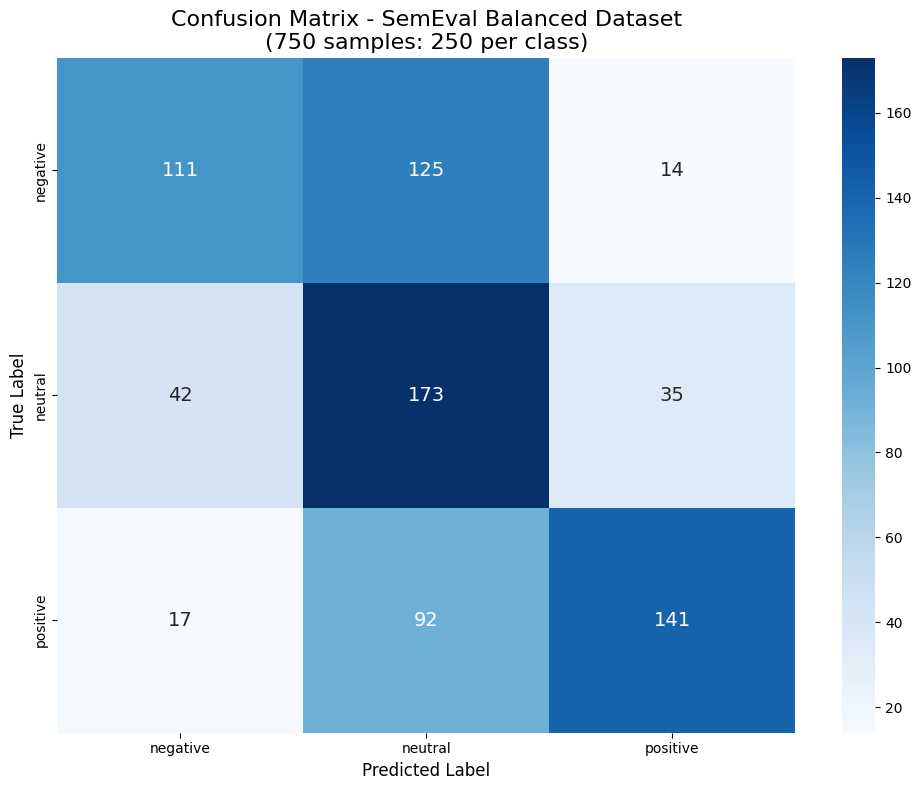


Confusion Matrix (numeric):
                                  Predicted                  
                   negative         neutral        positive    
------------------------------------------------------------
negative             111            125             14      
neutral               42            173             35      
positive              17             92            141      


In [19]:
# Vẽ Confusion Matrix
print("=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 14}
)
plt.title('Confusion Matrix - SemEval Balanced Dataset\n(750 samples: 250 per class)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# In confusion matrix dạng số
print("\nConfusion Matrix (numeric):")
print(f"{'':15} {'Predicted':^45}")
print(f"{'':15} {'negative':^15} {'neutral':^15} {'positive':^15}")
print("-" * 60)
for i, true_class in enumerate(label_encoder.classes_):
    row = f"{true_class:15}"
    for j in range(3):
        row += f" {cm[i][j]:^14}"
    print(row)

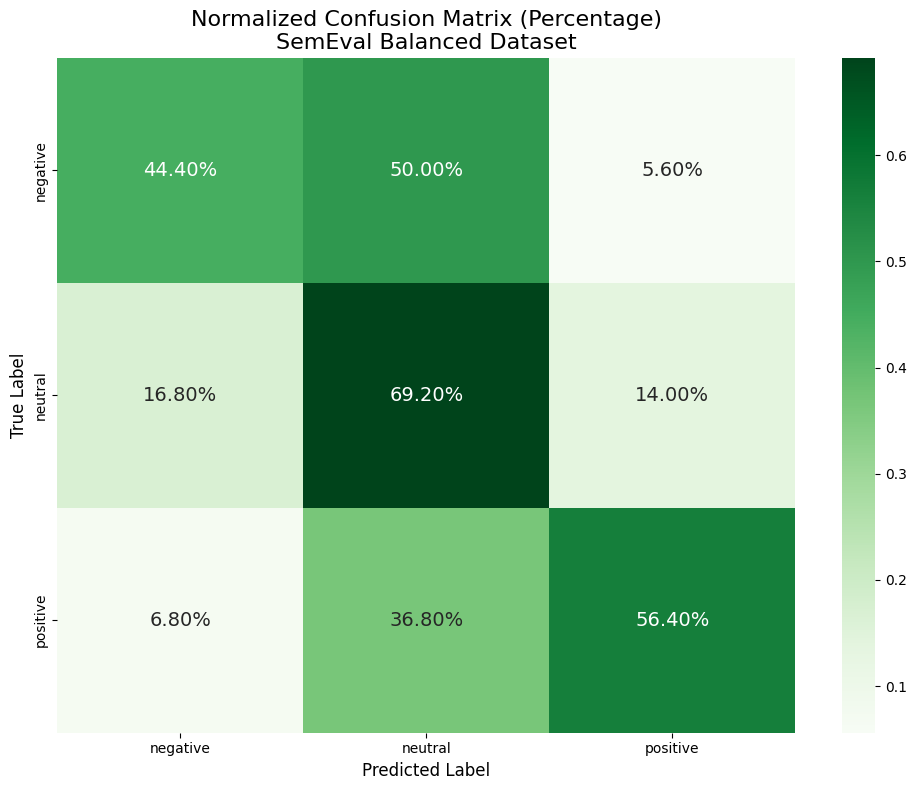

In [20]:
# Vẽ Normalized Confusion Matrix (percentage)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"size": 14}
)
plt.title('Normalized Confusion Matrix (Percentage)\nSemEval Balanced Dataset', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
# Hiển thị một số sample predictions
print("=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80)

# Lấy một số mẫu đúng và sai
correct_samples = df[df['Correct'] == True].sample(min(5, len(df[df['Correct'] == True])), random_state=42)
incorrect_samples = df[df['Correct'] == False].sample(min(5, len(df[df['Correct'] == False])), random_state=42)

print("\n✅ CORRECT PREDICTIONS:")
print("-" * 80)
for idx, row in correct_samples.iterrows():
    print(f"Text: {row['reviewText'][:80]}...")
    print(f"  True: {row['Sentiment']} | Predicted: {row['Predicted']}")
    print()

print("\n❌ INCORRECT PREDICTIONS:")
print("-" * 80)
for idx, row in incorrect_samples.iterrows():
    print(f"Text: {row['reviewText'][:80]}...")
    print(f"  True: {row['Sentiment']} | Predicted: {row['Predicted']}")
    print()

SAMPLE PREDICTIONS

✅ CORRECT PREDICTIONS:
--------------------------------------------------------------------------------
Text: I ate here a week ago and found most dishes average at best and too expensive....
  True: negative | Predicted: negative

Text: Food was good and the view of the new york city skiline was terrific even on a f...
  True: positive | Predicted: positive

Text: Not bad....
  True: neutral | Predicted: neutral

Text: Great, quick laptop for the money....
  True: neutral | Predicted: neutral

Text: Also the speakers are not very loud, But it is a netbook....
  True: neutral | Predicted: neutral


❌ INCORRECT PREDICTIONS:
--------------------------------------------------------------------------------
Text: For desserts, we tried the frozen black sesame mousse (interesting but not extra...
  True: neutral | Predicted: positive

Text: Easy to carry, can be taken anywhere, can be hooked up to printers,headsets....
  True: positive | Predicted: neutral

Text: They are

In [ ]:
# # Lưu kết quả prediction
# output_path = 'H:/SentimentAnalystSchool/MidtermExam/Dataset_Laptop_Restaurant/semeval/semeval_predictions.csv'
# df.to_csv(output_path, index=False)
# print(f"✓ Predictions saved to: {output_path}")

# # Summary
# print("\n" + "=" * 80)
# print("SUMMARY")
# print("=" * 80)
# print(f"📁 Dataset: semeval_balanced_540.csv")
# print(f"🔢 Total samples: {len(df)}")
# print(f"📊 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
# print(f"✅ Correct predictions: {df['Correct'].sum()}")
# print(f"❌ Incorrect predictions: {len(df) - df['Correct'].sum()}")
# print("=" * 80)